<a href="https://colab.research.google.com/github/KurraThejoram/timeseries/blob/master/TimeSeriesForecasting%2CTJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries , Read & Understand the data 

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import files
dataset = files.upload()

Saving train_csv.csv to train_csv (1).csv


In [0]:
import io
dataset = pd.read_csv(io.BytesIO(uploaded['train_csv.csv']))

In [11]:
dataset.head()

,id,time,feature
0,0,2019-03-19 00:00:00,237.97
1,1,2019-03-19 00:00:10,57.93
2,2,2019-03-19 00:00:20,90.53
3,3,2019-03-19 00:00:30,260.75
4,4,2019-03-19 00:00:40,49.70


In [12]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       80 non-null     int64  
 1   time     80 non-null     object 
 2   feature  80 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.0+ KB


### we can see that #id# wont play major role in preparing the model so we are removing 'id'from our data set

In [0]:
dataset.drop('id',axis=1,inplace=True)

variable 'time' is given object type in the data 

so we are converting the strings  into datetime using pd.datetime

In [0]:
dataset['time']=pd.to_datetime(dataset['time'],infer_datetime_format=True)

In [15]:
dataset.head(7)

,time,feature
0,2019-03-19 00:00:00,237.97
1,2019-03-19 00:00:10,57.93
2,2019-03-19 00:00:20,90.53
3,2019-03-19 00:00:30,260.75
4,2019-03-19 00:00:40,49.70
5,2019-03-19 00:00:50,302.08
6,2019-03-19 00:01:00,152.25


we are making time as our index for furthur processing

In [0]:
indexedDataset=dataset.set_index(['time'])

In [17]:
indexedDataset.head()

,feature
time,
2019-03-19 00:00:00,237.97
2019-03-19 00:00:10,57.93
2019-03-19 00:00:20,90.53
2019-03-19 00:00:30,260.75
2019-03-19 00:00:40,49.70


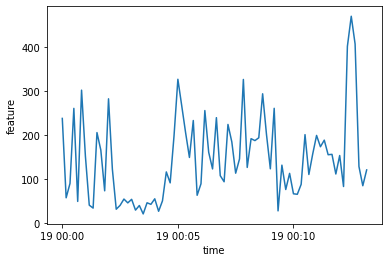

In [18]:
plt.xlabel("time")
plt.ylabel("feature")
plt.plot(indexedDataset)

this is how our data looks like 

if we observe carefully there is a trend which doesn't have stationary (constant mean)


In [19]:
#rolling statistics 
rolmean=indexedDataset.rolling(window=6).mean()

rolstd=indexedDataset.rolling(window=6).std()

print(rolmean,rolstd)

                        feature
time                           
2019-03-19 00:00:00         NaN
2019-03-19 00:00:10         NaN
2019-03-19 00:00:20         NaN
2019-03-19 00:00:30         NaN
2019-03-19 00:00:40         NaN
...                         ...
2019-03-19 00:12:30  229.476667
2019-03-19 00:12:40  271.198333
2019-03-19 00:12:50  274.031667
2019-03-19 00:13:00  262.606667
2019-03-19 00:13:10  268.875000

[80 rows x 1 columns]                         feature
time                           
2019-03-19 00:00:00         NaN
2019-03-19 00:00:10         NaN
2019-03-19 00:00:20         NaN
2019-03-19 00:00:30         NaN
2019-03-19 00:00:40         NaN
...                         ...
2019-03-19 00:12:30  163.381057
2019-03-19 00:12:40  172.702778
2019-03-19 00:12:50  169.679862
2019-03-19 00:13:00  181.301873
2019-03-19 00:13:10  174.389767

[80 rows x 1 columns]


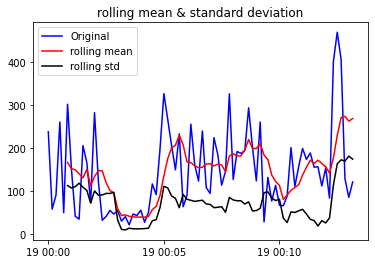

In [20]:
#plotting the rolling statistics
orig=plt.plot(indexedDataset,color='blue',label='Original')
mean=plt.plot(rolmean,color='red',label='rolling mean')
std=plt.plot(rolstd,color='black',label='rolling std')
plt.legend(loc='best')
plt.title("rolling mean & standard deviation")
plt.show()

The above graph shows that our rolling mean and standard deviations are not constant

we can strongly conclude that our data is not Stationary

ADF TEST

In [21]:
from statsmodels.tsa.stattools import adfuller

print("Results o dickey fuller test:")
dftest = adfuller(indexedDataset['feature'],autolag='AIC') #Akaike information criterion  
                                                           #shows exact value an analyzes the differences

dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','Pvalue','Lagsused','no of obs used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
print(dfoutput)

Results o dickey fuller test:
Test Statistic         -5.945866e+00
Pvalue                  2.205049e-07
Lagsused                0.000000e+00
no of obs used          7.900000e+01
Critical Value (1%)    -3.515977e+00
Critical Value (5%)    -2.898886e+00
Critical Value (10%)   -2.586694e+00
dtype: float64


dickeyfuller test results shows that p-value we got is so high i.e.,2.2 [considered value is <=0.5]

also our test statistic should be more than our critical values

this again shows that our data is not stationary

NOW LETS APPLY LOG FOR OUR VALUES AND CHECK THE SAME 

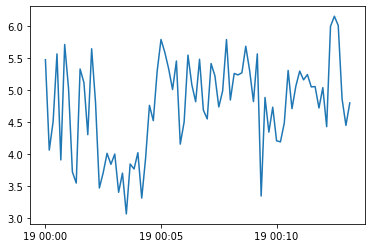

In [22]:
#estimate trend
indexedDataset_logscale = np.log(indexedDataset)
plt.plot(indexedDataset_logscale)

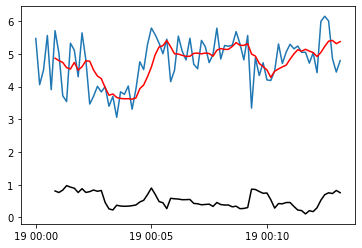

In [23]:
movingaverage = indexedDataset_logscale.rolling(window=6).mean()
movingSTD = indexedDataset_logscale.rolling(window=6).std()
plt.plot(indexedDataset_logscale)
plt.plot(movingaverage,color='red')
plt.plot(movingSTD,color='black')

After applying log also our mean and std are not stationary

To get our data stationary we are aught to do required transformations to our data

so here we are subtracting moving average from each data

In [24]:
datasetlogscaleminusmovingaverage = indexedDataset_logscale - movingaverage
datasetlogscaleminusmovingaverage.head(12)

datasetlogscaleminusmovingaverage.dropna(inplace=True)
datasetlogscaleminusmovingaverage.head()

,feature
time,
2019-03-19 00:00:50,0.841139
2019-03-19 00:01:00,0.230407
2019-03-19 00:01:10,-1.020081
2019-03-19 00:01:20,-1.033878
2019-03-19 00:01:30,0.788611


ADF test for newly transformed data

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #rolling statistics
    
    movingaverage = timeseries.rolling(window=6).mean()
    movingstd = timeseries.rolling(window=6).std()

    #plot rolling statistics
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(movingaverage,color='red',label='rolling mean')
    std=plt.plot(movingstd,color='black',label='rolling std')
    plt.legend(loc='best')
    plt.title("rolling mean & standard deviation")
    plt.show(block=False)

    #perform dickey fuller test
    print("Results o dickey fuller test:")
    dftest = adfuller(timeseries['feature'],autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','Pvalue','Lagsused','no of obs used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

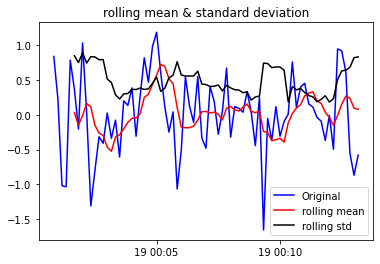

Results o dickey fuller test:
Test Statistic         -6.612986e+00
Pvalue                  6.308536e-09
Lagsused                0.000000e+00
no of obs used          7.400000e+01
Critical Value (1%)    -3.521980e+00
Critical Value (5%)    -2.901470e+00
Critical Value (10%)   -2.588072e+00
dtype: float64


In [26]:
test_stationarity(datasetlogscaleminusmovingaverage)

lets see the weighted average 

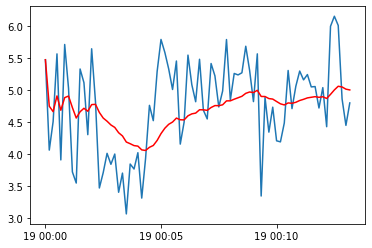

In [27]:
exponentialdecayweightedaverage = indexedDataset_logscale.ewm(halflife=12, min_periods=0,adjust=True).mean()
plt.plot(indexedDataset_logscale)
plt.plot(exponentialdecayweightedaverage,color='red')

here the mean keeps on changing with respect to trend

now lets transform the data like

subtract the exponential averge feom logscale

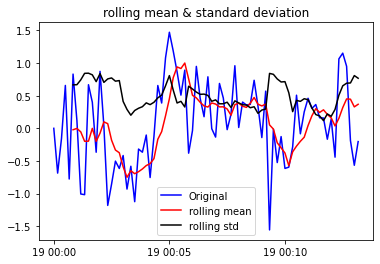

Results o dickey fuller test:
Test Statistic          -4.271237
Pvalue                   0.000498
Lagsused                 1.000000
no of obs used          78.000000
Critical Value (1%)     -3.517114
Critical Value (5%)     -2.899375
Critical Value (10%)    -2.586955
dtype: float64


In [28]:
datasetlogscaleminusmovingexpoentialaverage = indexedDataset_logscale - exponentialdecayweightedaverage
test_stationarity(datasetlogscaleminusmovingexpoentialaverage)

even here also we couldnot get the stationary values

Earlier we had subtracted the mean from actual value now we are using the shift() function to shift all of those values

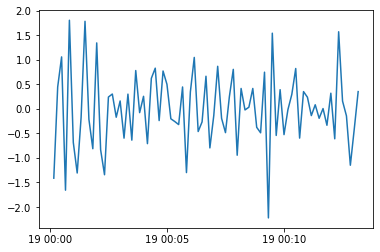

In [29]:
datasetlogdiffshifting = indexedDataset_logscale - indexedDataset_logscale.shift()
plt.plot(datasetlogdiffshifting)

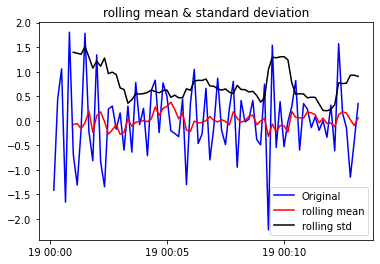

Results o dickey fuller test:
Test Statistic         -1.049024e+01
Pvalue                  1.152048e-18
Lagsused                1.000000e+00
no of obs used          7.700000e+01
Critical Value (1%)    -3.518281e+00
Critical Value (5%)    -2.899878e+00
Critical Value (10%)   -2.587223e+00
dtype: float64


In [30]:
datasetlogdiffshifting.dropna(inplace=True)
test_stationarity(datasetlogdiffshifting)

here we can see that in this step [datasetlogdiffshifting]

rolling statistics plotting shows that rolling mean is better compared to previous one

also our null hypothesus got rejected and we tried to get optimised stage of avg mean

Now lets see the components of timeseries

Trend,Seasonal,Residual

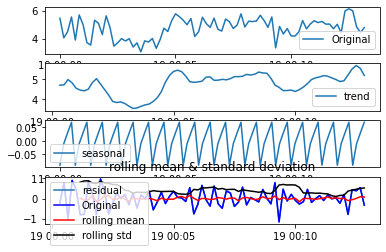

Results o dickey fuller test:
Test Statistic         -6.876763e+00
Pvalue                  1.467843e-09
Lagsused                5.000000e+00
no of obs used          7.000000e+01
Critical Value (1%)    -3.527426e+00
Critical Value (5%)    -2.903811e+00
Critical Value (10%)   -2.589320e+00
dtype: float64


In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logscale , freq=4)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logscale,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='residual')
plt.legend(loc='best')

decomposedLogData=residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

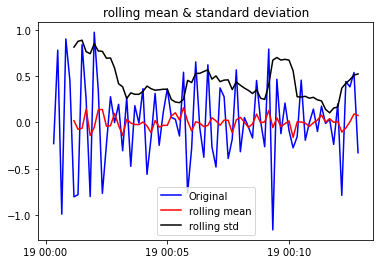

Results o dickey fuller test:
Test Statistic         -6.876763e+00
Pvalue                  1.467843e-09
Lagsused                5.000000e+00
no of obs used          7.000000e+01
Critical Value (1%)    -3.527426e+00
Critical Value (5%)    -2.903811e+00
Critical Value (10%)   -2.589320e+00
dtype: float64


In [32]:
#personal interaction with decomposed log data
decomposedLogData=residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

Text(0.5, 1.0, 'Partial Auto correlation function')

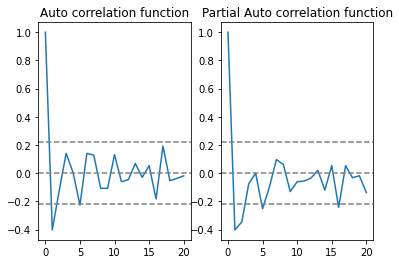

In [33]:
#ACF and PACF grphs
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(datasetlogdiffshifting, nlags=20)
lag_pacf = pacf(datasetlogdiffshifting, nlags=20,method='ols')

#plot acf
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='grey')
plt.axhline(y=1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='grey')
plt.title("Auto correlation function")

#plot pcaf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='grey')
plt.axhline(y=-1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='grey')
plt.axhline(y=1.96/np.sqrt(len(datasetlogdiffshifting)),linestyle='--',color='grey')
plt.title("Partial Auto correlation function")


here we can see in the ACF graph the line first touches the 0 at 1 in x axis so q=1

similarly in the PACF graph the line first touches the 0 at 1 in x axis so p=1

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


plotting AR model


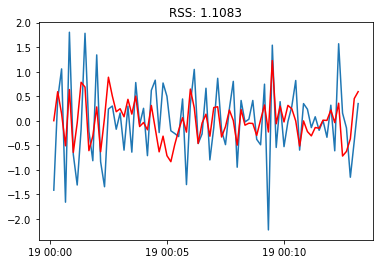

In [34]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(indexedDataset_logscale,order=(1,1,1))
results_AR = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues-datasetlogdiffshifting['feature'])**1))
print("plotting AR model")

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


plotting AR model


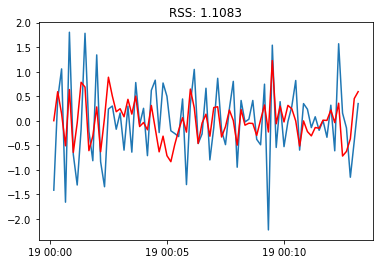

In [35]:
#MA MODEL
model = ARIMA(indexedDataset_logscale,order=(1,1,1))
results_MA = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues-datasetlogdiffshifting['feature'])**1))
print("plotting AR model")

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


plotting AR model


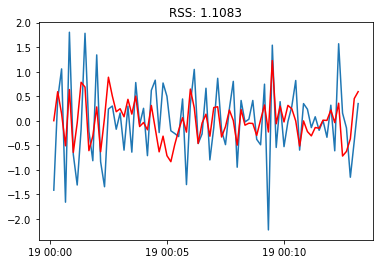

In [36]:
model = ARIMA(indexedDataset_logscale,order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetlogdiffshifting)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues-datasetlogdiffshifting['feature'])**1))
print("plotting AR model")

converting the fitted values to the series 

In [37]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head())

time
2019-03-19 00:00:10    0.002750
2019-03-19 00:00:20    0.593497
2019-03-19 00:00:30    0.144994
2019-03-19 00:00:40   -0.508348
2019-03-19 00:00:50    0.637065
dtype: float64


taking the cumulative sum 

In [38]:
predictions_ARIMA_diff_cumsum= predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

time
2019-03-19 00:00:10    0.002750
2019-03-19 00:00:20    0.596247
2019-03-19 00:00:30    0.741242
2019-03-19 00:00:40    0.232894
2019-03-19 00:00:50    0.869959
dtype: float64


In [39]:
predictions_ARIMA_log = pd.Series(indexedDataset_logscale['feature'],index=indexedDataset_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

time
2019-03-19 00:00:00    5.472145
2019-03-19 00:00:10    4.061986
2019-03-19 00:00:20    5.101929
2019-03-19 00:00:30    6.304804
2019-03-19 00:00:40    4.138899
dtype: float64

using exponential we are converting the predictions to the previous type data which is normal 

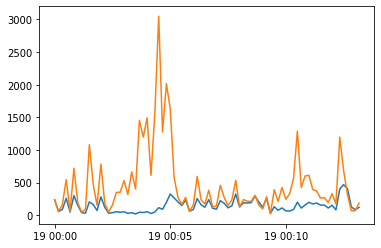

In [40]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

the above graph shows the model

Magnitude is variying but whereas the shape is correctly captured

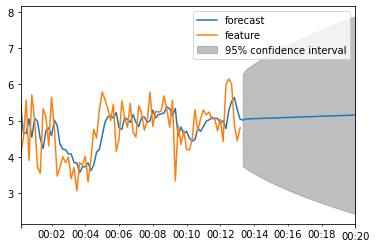

In [41]:
results_ARIMA.plot_predict(1,120)
x=results_ARIMA.forecast(steps=40)

this is the prediction

with 95% confidence intervel

In [0]:
forecast = results_ARIMA.forecast(steps=40)[0]

READ THE TESTDATA FOR FORECASTING

In [43]:
from google.colab import files
dataset = files.upload()

Saving test_csv.csv to test_csv.csv


In [0]:
import io
data_to_pred = pd.read_csv(io.BytesIO(dataset['test_csv.csv']))

In [47]:
data_to_pred.head()

,id,time
0,80,2019-03-19 00:13:20
1,81,2019-03-19 00:13:30
2,82,2019-03-19 00:13:40
3,83,2019-03-19 00:13:50
4,84,2019-03-19 00:14:00


In [0]:
data_to_pred.drop('id',axis=1,inplace=True)

In [0]:
data_to_pred['time']=pd.to_datetime(data_to_pred['time'],infer_datetime_format=True)

In [50]:
data_to_pred.set_index(['time']).head()

""
time
2019-03-19 00:13:20
2019-03-19 00:13:30
2019-03-19 00:13:40
2019-03-19 00:13:50
2019-03-19 00:14:00


In [0]:
data_to_pred['forecast'] = forecast

In [52]:
data_to_pred.head()

,time,forecast
0,2019-03-19 00:13:20,5.016785
1,2019-03-19 00:13:30,5.043276
2,2019-03-19 00:13:40,5.048620
3,2019-03-19 00:13:50,5.051654
4,2019-03-19 00:14:00,5.054435


In [53]:
FinalPrediction = np.exp(data_to_pred['forecast'])
FinalPrediction.head()

0    150.925361
1    154.976876
2    155.807350
3    156.280734
4    156.715979
Name: forecast, dtype: float64